# Cloud impact on precipitation and zonal wind at 850hPa by means of amip cloud-on and cloud-off simulations

This notebook reproduces Figure 3.

Data was downloaded by Nicole Albern from ESGF and CERE and postprocessed by Aiko Voigt.

### Load libraries

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

For reference, print package versions to screen:

In [2]:
print('xarrary:   ', xr.__version__)
print('numpy:     ', np.__version__)
import matplotlib; print('matplotlib:', matplotlib.__version__); del matplotlib
import cartopy; print('cartopy:   ', cartopy.__version__); del cartopy

xarrary:    0.15.1
numpy:      1.18.1
matplotlib: 3.2.1
cartopy:    0.17.0


### Load data

In [3]:
def load_data(var, exp):
    models=['CNRM-CM5', 'HadGEM2-A', 'IPSL-CM5A-LR', 'MPI-CM5', 'MRI-CGCM3']
    ds_list = []
    for mod in models:
        ds_list.append(xr.open_dataset('../../data/cookie/'+var+'_'+mod+'_'+exp+'.timmean_1980-2008.remapcon_r180x90.nc').squeeze())
    return ds_list

p_on  = load_data('pr', 'amip')
p_off = load_data('pr', 'offamip_mm')

u_on  = load_data('ua850', 'amip')
u_off = load_data('ua850', 'offamip_mm')

### Horizontal grid information

In [4]:
lon = p_on[0].lon
lat = p_on[0].lat

### Calculate model mean for cloud-on and cloud-off simulations

In [5]:
def get_modelmean(ds, var):
    mm = np.zeros((ds[0].lat.size, ds[0].lon.size))
    for i in range(len(ds)):
        mm = mm + ds[i][var].values
    return mm / len(ds)

In [6]:
p_on_mm  = get_modelmean(p_on , 'pr')
p_off_mm = get_modelmean(p_off, 'pr')

u_on_mm  = get_modelmean(u_on , 'ua')
u_off_mm = get_modelmean(u_off, 'ua')

### Calculate model consensus for difference between cloud-on and cloud-off simulation

Note: if all models agree on sign, then con=1, otherwise con=0

In [7]:
# model consensus for lat-lon data
def get_modelconsensus_latlon(ds1, ds2, var):
    con = np.zeros((ds1[0].lat.size, ds1[0].lon.size))
    for i in range(len(ds1)):
        con = con + np.sign(ds1[i][var].values-ds2[i][var].values)
    con = np.abs(con)
    con[con<len(ds1)] = 0.0
    con[con==len(ds1)] = 1.0
    return con

# model consenus for zonal-mean data
def get_modelconsensus_zm(ds1, ds2, var):
    con = np.zeros(ds1[0].lat.size)
    for i in range(len(ds1)):
        con = con + np.sign(ds1[i][var].mean('lon').values-ds2[i][var].mean('lon').values)
    con = np.abs(con)
    con[con<len(ds1)] = 0.0
    con[con==len(ds1)] = 1.0
    return con

In [8]:
dp_con    = get_modelconsensus_latlon(p_on, p_off , 'pr')
dp_zm_con = get_modelconsensus_zm(p_on, p_off, 'pr')

du_con    = get_modelconsensus_latlon(u_on, u_off , 'ua')
du_zm_con = get_modelconsensus_zm(u_on, u_off, 'ua')

/home/fd8940/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
/home/fd8940/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fd8940/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less


### Plotting 

Precipitation map

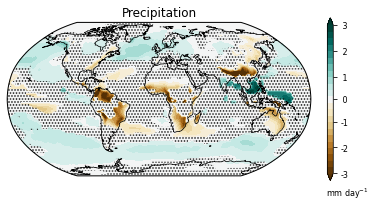

In [9]:
plt.figure(figsize=(5.915, 3))

clev = np.array([-3.0,-2.75,-2.5,-2.25,-2.0,-1.75,-1.5,-1.25,-1.0,-0.75,-0.5,-0.25,
                 0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0])
aux=86400*(p_on_mm-p_off_mm)*dp_con
pdata, lons = add_cyclic_point(aux, coord=lon)
lats =lat
ax = plt.axes(projection=ccrs.Robinson())
c1=plt.contourf(lons, lats, np.clip(pdata,a_max=90,a_min=-90.0), clev,
             transform=ccrs.PlateCarree(), cmap='BrBG', extend='both')

ax.coastlines(resolution='110m', linewidth=0.75)
cb=plt.colorbar(c1,aspect=25,fraction=0.03, format='% 1.0f')
cb.set_ticks([-3.0,-2.0,-1.0,0,1.0,2.0,3.0]) # vertically oriented colorbar
cb.ax.tick_params(labelsize=8)
plt.title('Precipitation', fontsize=12)
ax.text(1.05,-0.13,r'mm day$^{-1}$', fontsize=8,transform=ax.transAxes)

# stippling, where models do not agree on response
stip, lons = add_cyclic_point(np.abs(dp_con-1), coord=lon)
stip[stip==0]=np.nan
plt.pcolor(lons, lats, stip, hatch='....', alpha=0.0, #rasterized=True,
           transform=ccrs.PlateCarree())

plt.savefig('figure-3a.png', dpi=1000)

Zonal wind

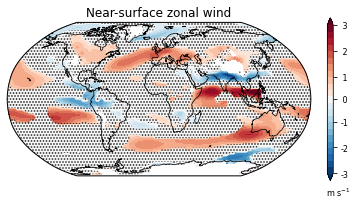

In [10]:
plt.figure(figsize=(5.915, 3))

clev = np.array([-3.0,-2.75,-2.5,-2.25,-2.0,-1.75,-1.5,-1.25,-1.0,-0.75,-0.5,-0.25,
                 0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0])
aux=(u_on_mm-u_off_mm)*du_con
pdata, lons = add_cyclic_point(aux, coord=lon)
lats = lat
ax = plt.axes(projection=ccrs.Robinson())
c1=plt.contourf(lons, lats, np.clip(pdata,a_max=90,a_min=-90.0), clev,
             transform=ccrs.PlateCarree(), cmap='RdBu_r', extend='both')

ax.coastlines(resolution='110m', linewidth=0.75)
cb=plt.colorbar(c1,aspect=25,fraction=0.03, format='% 1.0f')
cb.set_ticks([-3.0,-2.0,-1.0,0,1.0,2.0,3.0]) # vertically oriented colorbar
cb.ax.tick_params(labelsize=8)
plt.title('Near-surface zonal wind', fontsize=12)
ax.text(1.05,-0.13,r'm s$^{-1}$', fontsize=8,transform=ax.transAxes)

# stippling, where models do not agree on response
stip, lons = add_cyclic_point(np.abs(du_con-1), coord=lon)
stip[stip==0]=np.nan
plt.pcolor(lons, lats, stip, hatch='....', alpha=0.0, #rasterized=True,
           transform=ccrs.PlateCarree())

plt.savefig('figure-3c.png', dpi=1000)

Zonal mean of precipitation and zonal wind

/home/fd8940/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice
/home/fd8940/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in less
/home/fd8940/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fd8940/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fd8940/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fd8940/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice


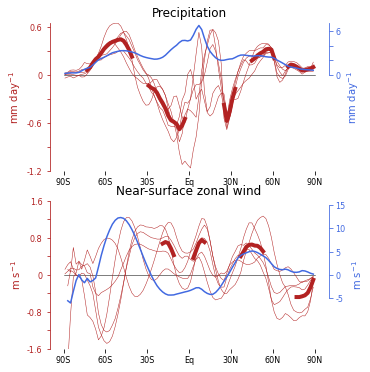

In [11]:
plt.figure(figsize=(5,6))

# precipitation
ax=plt.subplot(2,1,1)
ax.spines['bottom'].set_bounds(-90,90)
ax.spines['bottom'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('firebrick')
ax.tick_params(axis='y', colors='firebrick')
plt.plot([-90,90],[0,0], 'k', linewidth=0.5)
mm=86400*(p_on_mm-p_off_mm).mean(axis=1); mm[dp_zm_con!=1]=np.nan
plt.plot(lat, mm, 'firebrick',linewidth=4)
for m in range(5):
    plt.plot(lat,86400*(p_on[m]-p_off[m])['pr'].mean('lon'),'firebrick',linewidth=0.5)
plt.xlim(-100,100); plt.ylim(-1.2,0.65)
ax.xaxis.set_ticks([-90,-60,-30,0,30,60,90])
ax.xaxis.set_ticklabels(['90S', '60S', '30S', 'Eq', '30N', '60N', '90N'], fontsize=8)
ax.yaxis.set_ticks([-1.2,-0.9,-0.6,-0.3,0,0.3,0.6])
ax.yaxis.set_ticklabels([-1.2,'',-0.6,'',0,'',0.6], fontsize=8)
ax.set_ylabel(r'mm day$^{-1}$', fontsize=10, color='firebrick')

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
ax2.spines['right'].set_bounds(0,0.65*11)
ax2.spines['bottom'].set_color('none')
ax2.spines['top'].set_color('none')
ax2.spines['left'].set_color('none')
ax2.spines['right'].set_color('royalblue')
ax2.tick_params(axis='y', colors='royalblue')
plt.plot(lat, 86400*(p_on_mm).mean(axis=1), 'royalblue')
plt.xlim(-100,100); plt.ylim(-1.2*11,0.65*11)
ax2.yaxis.set_ticks([0,2,4,6])
ax2.yaxis.set_ticklabels([0,'','',6], fontsize=8, color='royalblue')
plt.title(r'Precipitation', fontsize=12)
ax2.set_ylabel(r'mm day$^{-1}$', fontsize=10, color='royalblue')

# 850 hPa zonal wind
ax=plt.subplot(2,1,2)
ax.spines['bottom'].set_bounds(-90,90)
ax.spines['bottom'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('firebrick')
ax.tick_params(axis='y', colors='firebrick')
plt.plot([-90,90],[0,0], 'k', linewidth=0.5)
mm=np.nanmean(u_on_mm-u_off_mm, axis=1); mm[du_zm_con<0.99]=np.nan
plt.plot(lat, mm, 'firebrick',linewidth=4)
for m in range(5):
    plt.plot(lat,(u_on[m]-u_off[m])['ua'].mean('lon'),'firebrick',linewidth=0.5)
plt.xlim(-100,100); plt.ylim(-1.5,1.5)
ax.xaxis.set_ticks([-90,-60,-30,0,30,60,90]);
ax.xaxis.set_ticklabels(['90S', '60S', '30S', 'Eq', '30N', '60N', '90N'], fontsize=8);
ax.yaxis.set_ticks([-1.6,-1.2,-0.8,-0.4,0,0.4,0.8,1.2,1.6]);
ax.yaxis.set_ticklabels([-1.6,'',-0.8,'',0,'',0.8,'',1.6], fontsize=8);
ax.set_ylabel(r'm s$^{-1}$', fontsize=10, color='firebrick')

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
ax2.spines['right'].set_bounds(-5,15)
ax2.spines['bottom'].set_color('none')
ax2.spines['top'].set_color('none')
ax2.spines['left'].set_color('none')
ax2.spines['right'].set_color('royalblue')
ax2.tick_params(axis='y', colors='royalblue')
plt.plot(lat, np.nanmean(u_on_mm,axis=1), 'royalblue')
plt.xlim(-100,100); plt.ylim(-1.6*10,1.6*10)
ax2.yaxis.set_ticks([-5,0,5,10,15])
ax2.yaxis.set_ticklabels([-5,0,5,10,15], fontsize=8, color='royalblue');
plt.title(r'Near-surface zonal wind', fontsize=12)
ax2.set_ylabel(r'm s$^{-1}$', fontsize=10, color='royalblue')

plt.savefig('figure3-b-d.pdf')